# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: Data Description, Cleaning, Exploratory Data Analysis, and Preprocessing</b></center>
<br>

**by**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

### **dataset description**

The Twitter Sentiments Dataset is a dataset that contains nearly 163k tweets from Twitter. The time period of when these were collected is unknown, but it was published to Mendeley Data on May 14, 2021 by Sherif Hussein of Mansoura University.

Tweets were extracted using the Twitter API, but the specifics of how the tweets were selected are unmentioned. The tweets are mostly English with a mix of some Hindi words for code-switching <u>(El-Demerdash., 2021)</u>. All of them seem to be talking about the political state of India. Most tweets mention Narendra Modi, the current Prime Minister of India.

Each tweet was assigned a label using TextBlob's sentiment analysis <u>(El‑Demerdash, Hussein, & Zaki, 2021)</u>, which assigns labels automatically.

Twitter_Data

- **`clean_text`**: The tweet's text
- **`category`**: The tweet's sentiment category

What each row and column represents: `each row represents one tweet.` <br>
Number of observations: `162,980`

---

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Code-switching is the practice of alternating between two languages $L_1$ (the native language) and $L_2$ (the source language) in a conversation. In this context, the code-switching is done to appear more casual since the conversation is done via Twitter (now, X).


## **1. Project Set-up**

We set the global imports for the projects (ensure these are installed via uv and is part of the environment). Furthermore, load the dataset here.


In [185]:
import pandas as pd
import numpy as np
import os
import sys

# Use lib directory
sys.path.append(os.path.abspath("../lib"))

# Imports from lib files
from janitor import *
from lemmatize import lemmatizer
from boilerplate import stopwords_set
from bag_of_words import BagOfWordsModel

# Pandas congiruation
pd.set_option("display.max_colwidth", None)

# Load raw data file
df = pd.read_csv("../data/Twitter_Data.csv")

## **2. Data Cleaning**

This section discusses the methodology for data cleaning.


As to not waste computational time, a preliminary step is to ensure that no **`NaN`** or duplicate entries exist before the cleaning steps. We can call on `info()` after each step to see the rows changed in our DataFrame


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


There are clear inconsistencies with the amount of non-null values between column **`clean_text`** and **`category`** versus the total entries, so our first step would be to drop the `NaN` entries. We can first check which rows have **`category`** as **`NaN`**.


In [187]:
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugurated modi came major,NaN
155642,dear terrorists you can run but you cant hide are giving more years modi which you won’ see you,NaN
155698,offense the best defence with mission shakti modi has again proved why the real chowkidar our,NaN
155770,have always heard politicians backing out their promises but modi has been fulfilling his each every,NaN
158693,modi government plans felicitate the faceless nameless warriors india totally deserved,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 and the real reason why rahul doing the same now,NaN


We found that there were a total of 11 rows that have **`NaN`** values, thus we drop them to ensure the integrity and accuracy of our data analysis.


In [188]:
df = df.dropna()
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category


Another issue found commonly in real-world datasets would be duplicate rows, often from manual data entry errors, system glitches, or when merging data from multiple, overlapping sources. We can first check for duplicates in our `DataFrame` then remove them.

> 🍠 do i need to cite this


In [189]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,clean_text,category


There exist no duplicate rows within our `DataFrame`.


By converting a CSV file into a DataFrame, pandas automatically defaults numeric values to `float64` when it encounters decimals or **`NaN`** types. Text of `str` type get inferred and loaded into a `object` as the generic type for strings. We can check the dtype of our `DataFrame` columns through [`info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


We can see that **`clean_text`** column dtype is of `object` and category is of dytpe `float64`, to determine if the columns are assigned the right data type we check the unqiue values in each column.


In [191]:
for item in df["category"].unique():
    print(item)

-1.0
0.0
1.0


In [192]:
for item in df["clean_text"].unique()[:3]:
    print(item)

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
talk all the nonsense and continue all the drama will vote for modi 
what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax


Now that we have seen the unique values of each column, we can safely say that the data types assigned to both columns were not the right ones.


We first will convert column **`category`** from `float64` to `int64` considering that the range of values (**`-1`**, **`0`**, **`1`**) for a tweet's sentiment category will only ever be whole numbers. This step is done after dropping **`NaN`** value rows because **`NaN`** is fundamentally a float type.


In [193]:
df["category"] = df["category"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


After successfully converting the **`category`** column into `int64`, next we convert column `clean_string` from `object` type into the pandas defined `string` type for consistency and better performance.


In [194]:
df["clean_text"] = df["clean_text"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


We are now finished with the _initial_ data cleaning steps, this level is more focused on the standard or common issues present in public datasets and the cleaning of it before we move onto our main cleaning pipeline, which would be more focused on cleaning the tweets themselves.


## **Main Cleaning Pipeline**

We follow a similar methodology for data cleaning presented in (George & Murugesan, 2024).


### **Normalization**

Due to the nature of the text being tweets, the presence of emojis and accented characters are to be expected. To see if our data has these special characters, we selected a sample set of them to be displayed if they were in **`clean_text`**.


In [195]:
# Finding a sample of rows with emojis
rows_with_emojis = df[df["clean_text"].str.contains(r"[\u263a-\U0001f645]", regex=True)]
rows_with_emojis["clean_text"].sample(5)

74646                                                           rahul praises scientists taunts modi with ‘happy world theatre day’ jibe ⚡andre russell 
80360                                                                                                                         king the world modi hai✔✔✔
129041                              shatabdi express serves chai cup with narendra modis main bhi chowkidar slogan photo goes viral india today ☄ ⛱ ✅ ⚡ 
145045                           when modi destroyed the dreams many rahul here help all achieve the dreams all✌ rahul leader all and leader for all❤️  
58969     many congratulations modi and our drdo and isro scientists secure indian space defences and bring country into 4th position worlds elite club✌
Name: clean_text, dtype: string

In [196]:
# Finding a sample of rows with accented characters
accented_char_rows = df[df["clean_text"].str.contains(r"É|é|Á|á|ó|Ó|ú|Ú|í|Í")]
accented_char_rows["clean_text"].sample(5)

92423                                  after advance social média are getting true picture congress they cheated india its development now modi doing 
82940                     arre madamwhy touché about name calling congress and supporters throw hat your called modi supporters bhakths and chowkidars
114173                                    you take break per pollsthose preferring over modiwill only expose their mental inadequacyimmaturitynaïveté 
59831                                                                             india shoots down satellite test modi hails arrival space power vía 
50461     vía not against any particular nation demonstration our own technology former drdo chief saraswat tells cnnnews18s follow live updates here 
Name: clean_text, dtype: string

Although in a real-world context these do serve as a form of emotional expression, they provide no relevance towards _textual_ sentiment analysis, thus we normalize the text.


To normalize the text, the `normalize` function was created. It normalizes the text input to ASCII-only characters (say, "cómo estás" becomes "como estas") and lowercased alphabetic symbols. The dataset contains Unicode characters (e.g., emojis and accented characters) which the function replaces to the empty string (`''`).


In [197]:
normalize??

Signature: normalize(text: str) -> str
Source:   
def normalize(text: str) -> str:
    """
    Normalize text from a pandas entry to ASCII-only lowercase characters. Hence, this removes Unicode characters with no ASCII
    equivalent (e.g., emojis and CJKs).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    ASCII-normalized text containing only lowercase letters.

    # Examples
    normalize("¿Cómo estás?")
    $ 'como estas?'

    normalize(" hahahaha HUY! Kamusta 😅 Mayaman $$$ ka na ba?")
    $ ' hahahaha huy! kamusta  mayaman $$$ ka na ba?'
    """
    normalized = unicodedata.normalize("NFKD", text)
    ascii_text = normalized.encode("ascii", "ignore").decode("ascii")

    return ascii_text.lower()
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Punctuations**

Punctuations are part of natural speech and reading to provide a sense of structure, clarity, and tone to sentences, but in the context of a classification study, punctuations do not add much information to the sentiment of a message. The sentiment of `i hate you!` and `i hate you` are going to be the same despite the punctuation mark `!` being used to accentuate the sentiment. We can see a sample of rows with punctations below.


In [198]:
# Finding a sample of rows with punctuation
rows_with_punc = df[df["clean_text"].str.contains(r"[^\w\s]")]
rows_with_punc["clean_text"].sample(5)

11422                                                                                          film why the upset over mistake deliberate error javed akhtar writing songits not like its mirza ghalib’ workthen the earth wud shake 
113679                                                                                   the rafale you know what the rafale its the thousand lies modi’ enemies story agree tell each other over and over until forget that its lie 
149896                                                                                                                                                   lok sabha elections 2019 modi interact with ‘main bhi chowkidar’ supporters 
107079    modi man grandeur theatrics and media galore likes create big moments and everlasting memories and likes shock and awe the nation with his ‘surgical strikes’ and ‘blitzkriegs’ you think movie can beat him latest column 
134435    filing nomination for gandhinagar seat turned into the nda rally minus

To address this, the function `rem_punctuation` was made, which replaces all punctuations and special characters with an empty string (`''`)


In [199]:
rem_punctuation??

Signature: rem_punctuation(text: str) -> str
Source:   
def rem_punctuation(text: str) -> str:
    """
    Removes the punctuations. This function simply replaces all punctuation marks and special characters
    to the empty string. Hence, for symbols enclosed by whitespace, the whitespace are not collapsed to a single whitespace
    (for more information, see the examples).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the punctuation removed.

    # Examples
    rem_punctuation("this word $$ has two spaces after it!")
    $ 'this word  has two spaces after it'

    rem_punctuation("these!words@have$no%space")
    $ 'thesewordshavenospace'
    """
    return re.sub(f"[{re.escape(string.punctuation)}]", "", text)
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Numbers**

Similar to punctuations, numbers do not add any information to the sentiment of a message.


In [200]:
# Finding a sample of rows that contain numbers
rows_with_numbers = df[df["clean_text"].str.contains(r"\d")]
rows_with_numbers["clean_text"].sample(5)

13941                                                                                                                                                                                        modi learning new maths which 1200012 becomes 72000
133913    thanks for your great thoughts and works for mission new india 2019 with sri modi all real great lndians are with our own great lndian prime minister respected sri modi thanks from patna pandey and friends with all the best wishes
54110                          had done while there npt like treaty slated for negotiation june modi modi this deal will include india and prevent npt type issues and embargo post nuclear test pokhran rush the authority who talked 2015 abt 
99006                           india providing gas replace polluting fuels\ngovernment programs successful curbing indoor pollution study finds 2017 india 500 000 deaths were due household air pollution\ngreat achievement india  more done 
124207         now the time election

Hence, we defined the `rem_numbers` as a function that replaces all numerical values as an empty string (`''`).


In [201]:
rem_numbers??

Signature: rem_numbers(text: str) -> str
Source:   
def rem_numbers(text: str) -> str:
    """
    Removes numbers. This function simply replaces all numerical symbols to the empty string. Hence, for symbols enclosed by
    whitespace, the whitespace are not collapsed to a single whitespace (for more information, see the examples).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the numerical symbol removed

    # Examples
    rem_numbers(" h3llo, k4must4 k4  n4?")
    ' hllo, kmust k  n?'
    """
    return re.sub(r"\d+", "", text)
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Whitespace**

Similar to punctations, whitespaces do not add any information to the text and are from user errors. We check if our data has whitespace.


In [202]:
# Finding a sample of rows that contain 2 or more whitespaces in a row
rows_with_whitespaces = df[df["clean_text"].str.contains(r"\s{2,}")]
rows_with_whitespaces["clean_text"].sample(5)

7699      nationalists every happy  deepa malik paralympian joining bjp the work that modi has done for women empowerment and his thoughts towards women evident has put women leading portfolios has also worked extensively for the divyangs 
153938                                                yes  she deserves stay pakistan  fact the whole kashmir integral part pakistan  including the indian muslims because they are living under the bloodbath government that modi chayee wala
22888                                                                                                                            modi and don’ lie  and his party whole five years gone lying  now try for truth can’ becz become addicted now 
107503                                                    rajdeep sonia how indira gandhi helped you the kitchen arnab modi you have violated election code conduct but according the libtards and all pidis rajdeep unbiased and arnab bhakt  
140696       never heard the name even s

Thus to address the problem, the function `collapse_whitespace` was made, which collapses all whitespace characters to a single space. Formally, it is a transducer

$$
\Box^+ \mapsto \Box \qquad \text{where the space character is } \Box
$$

Informally, it replaces all strings of whitespaces to a single whitespace character.


In [203]:
collapse_whitespace??

Signature: collapse_whitespace(text: str) -> str
Source:   
def collapse_whitespace(text: str) -> str:
    """
    This collapses whitespace. Here, collapsing means the transduction of all whitespace strings of any
    length to a whitespace string of unit length (e.g., "   " -> " "; formally " "+ -> " ").

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the whitespaces collapsed.

    # Examples
    collapse_whitespace("  huh,  was.  that!!! ")
    $ 'huh, was. that!!!'
    """
    return re.sub(" +", " ", text).strip()
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

To seamlessly call all these cleaning functions, we have the `clean` function that acts as a container that calls these separate components. The definition of this wrapper function is quite long, see [this appendix](#appendix:-clean-wrapper-function-definition) for its definition.

We can now clean the dataset and store it in a new column named `clean_ours` (to differentiate it with the, still dirty, column `clean_text` from the dataset author)


In [204]:
df["clean_ours"] = df["clean_text"].map(clean).astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162969 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


To confirm if the character cleaning worked, we can check for the differences between `clean_text` and `clean_ours` from the filtered rows below and compare the differences.


In [205]:
example_rows = df[
    df["clean_text"].str.contains(r"\s{2,}|\d|[^\w\s]|[\u263a-\U0001f645]|[ÉéÁáóÓúÚíÍ]")
]
example_rows.sample(10)

,clean_text,category,clean_ours
2226,smitri irani was graduate 2004 and 12th class pass 2019 like like her cabinet modi finished his first and then completed and has computerized mark sheet when computer existed only happens india,1,smitri irani was graduate and th class pass like like her cabinet modi finished his first and then completed and has computerized mark sheet when computer existed only happens india
14744,rahul sir next rally conference plzz ask jaitley that hes saying that making wrong promises then wht abt modi jis promise bringing 15l everyones account inko darr aap vaade poore krloge yeh bechare rehjayenge apni jeben bhrni thi inko,-1,rahul sir next rally conference plzz ask jaitley that hes saying that making wrong promises then wht abt modi jis promise bringing l everyones account inko darr aap vaade poore krloge yeh bechare rehjayenge apni jeben bhrni thi inko
59095,alleging that ’ announcement india’ achievement shooting down satellite was violation the model code conduct said that the will lodge complaint the,-1,alleging that announcement india achievement shooting down satellite was violation the model code conduct said that the will lodge complaint the
5875,modi promised rs6000 annually farmers budget bhakts great move modiji dil jeet liya yaarthis will empower farmers rahul promised minimum income guarantee rs6000month every poor citizen india bhakts sala mufatkhor bana sabkoluta desh paisa\n,1,modi promised rs annually farmers budget bhakts great move modiji dil jeet liya yaarthis will empower farmers rahul promised minimum income guarantee rsmonth every poor citizen india bhakts sala mufatkhor bana sabkoluta desh paisa
127055,pls define nyay who will entitled how you aim identify will beneficiary elligible next year how will you filtre income increases make way for someone else you know modi planning 25l mip for all,0,pls define nyay who will entitled how you aim identify will beneficiary elligible next year how will you filtre income increases make way for someone else you know modi planning l mip for all
902,100 bucks bet\nkangana will have scene jayalalitha were says modi her inspiration,0,bucks bet\nkangana will have scene jayalalitha were says modi her inspiration
2360,smelt defeat openion abot sing modi dropped bjp assembly 135,0,smelt defeat openion abot sing modi dropped bjp assembly
40886,didnt know modi was going take tweet seriously,-1,didnt know modi was going take tweet seriously
135699,you were lying about modi wave 2014 denying its existence you are lying now,0,you were lying about modi wave denying its existence you are lying now
130870,finally come the venue list campaign addressing modi 31st march19,0,finally come the venue list campaign addressing modi st march


We are now finished with basic text cleaning, but the data cleaning does not end here. Given that the text is sourced from Twitter, it includes characteristics, such as spam and informal expressions, which are not addressed by basic cleaning methods. As a result, we move on to further cleaning tailored to the nature of Twitter data.


### **Spam, Expressions, Onomatopoeia, etc.**

Since the domain of the corpus is Twitter, spam (e.g., `bbbb`), expressions (e.g., `bruhhhh`), and onomatopoeia (e.g., `hahahaha`) may become an issue by the vector representation step. Hence we employed a simple rule-based spam removal algorithm.

We remove words in the string that contains the same letter or substring thrice and consecutively. These were done using regular expressions:

$$
\text{same\_char\_thrice} := (.)\textbackslash1^{\{2,\}}
$$

and

$$
\text{same\_substring\_twice} := (.^+)\textbackslash1^+
$$

Furthermore, we also remove any string that has a length less than three, since these are either stopwords (that weren't detected in the stopword removal stage) or more spam.

Finally, we employ adaptive character diversity threshold for the string $s$.

$$
\frac{\texttt{\#\_unique\_chars}(s)}{|s|} < 0.3 + \left(\frac{0.1 \cdot \text{min}(|s|, 10)}{10}\right)
$$

It calculates the diversity of characters in a string; if the string repeats the same character alot, we expect it to be unintelligible or useless, hence we remove the string.

The definition of this wrapper function is quite long, see its definition in [this appendix](#appendix:-find_spam_and_empty-wrapper-function-definition).

Let's first look at a random sample of 10 entries from the dataset that will be modified by the function.


In [206]:
affected = df[df["clean_ours"].apply(spam_affected)]
affected_sample = affected["clean_ours"].sample(10)
affected_sample

115647                                                   already non nda candidates are asking votes saying just give this constituency one daring talk against modi roadshows down south here how resonates with voters turn out will know rd may
117308            modi namechangernot gamechanger mnrega aadhardirect benefits transfer renamed jan dhannirmal bharat abhiyanpackaged swachh bharat with huge publicity budgetfdi retailthe liberalisation insurance and gst itselfall upa schemes
147105           not about what pakistan refusing see about you didnt see modi using the indian air force changed what india chooses remember th february had abhinandan not needed eject modi would have succeeded changing the narrative aka uri
19798                    back rest will given out rahulji\nmore importantly this will greatly increase the labour force today only ppl are finding work due ahle modis notebandi and gabbar tax after nyay scheme every person will enroll mazdoor
107005    rural housing sche

Let's now call this function on the `clean_ours` column of the dataset.


In [207]:
df["clean_ours"] = df["clean_ours"].map(find_spam_and_empty).astype("string")

To confirm if the function was able to do remove all the spammy substrings, we can check `before` and `after` to compare their differences.


In [208]:
comparison = pd.DataFrame({"before": affected_sample, "after": df["clean_ours"]})

changed = comparison[comparison["before"] != comparison["after"]]
changed.sample(10)

,before,after
147105,not about what pakistan refusing see about you didnt see modi using the indian air force changed what india chooses remember th february had abhinandan not needed eject modi would have succeeded changing the narrative aka uri,not about what pakistan refusing see about you didnt see modi using the indian air force changed what india chooses remember february had abhinandan not needed eject modi would have succeeded changing the narrative aka uri
77509,modi aap aage badhiyedesh aapke saath hai please tell people that powerful government lead powerful makes powerful nation and the power make powerful lies the hands people ask them give thumping majorityabki baar paar good luck,modi badhiyedesh saath hai please tell people that powerful government lead powerful makes powerful nation and the power make powerful lies the hands people ask them give thumping majorityabki baar paar good luck
107005,rural housing scheme for the poor the toilet revolution crop insurance reduction indirect taxeselectricity connection free lpg cooking gas free healthcare ppl and farmers\ndon think any has done even what modi has just yrs for india,rural housing scheme for the poor the toilet revolution crop insurance reduction indirect taxeselectricity connection free lpg cooking gas free healthcare and farmers don think any has done even what modi has just yrs for india
149875,varanasi was never safe seat for modi because election bjp just barely scrap thru margin k votes just whereas was won congress with margin votes,varanasi was never safe seat for modi because election bjp just barely scrap thru margin votes just whereas was won congress with margin votes
115647,already non nda candidates are asking votes saying just give this constituency one daring talk against modi roadshows down south here how resonates with voters turn out will know rd may,already non nda candidates are asking votes saying just give this constituency one daring talk against modi roadshows down south here how resonates with voters turn out will know may
128564,modi have done surgical strike lutyens media show proof rahul k per year for all poor lutyens media need proof rahul great economist,modi have done surgical strike lutyens media show proof rahul per year for all poor lutyens media need proof rahul great economist
12545,hahaha man how funny this modi they are releasing his biopic make their public fool and saw the trailer which modi shouting pakistan pakistan pakistan pakistan,man how funny this modi they are releasing his biopic make their public fool and saw the trailer which modi shouting pakistan pakistan pakistan pakistan
117308,modi namechangernot gamechanger mnrega aadhardirect benefits transfer renamed jan dhannirmal bharat abhiyanpackaged swachh bharat with huge publicity budgetfdi retailthe liberalisation insurance and gst itselfall upa schemes,modi namechangernot gamechanger mnrega benefits transfer renamed jan dhannirmal bharat abhiyanpackaged swachh bharat with huge publicity budgetfdi retailthe liberalisation insurance and gst itselfall upa schemes
137046,agree with you then tell when will a get scrapped modi elected again can can assess when can have total peace normal life the valley,agree with you then tell when will get scrapped modi elected again can can assess when can have total peace normal life the valley
19798,back rest will given out rahulji\nmore importantly this will greatly increase the labour force today only ppl are finding work due ahle modis notebandi and gabbar tax after nyay scheme every person will enroll mazdoor,back rest will given out rahulji more importantly this will greatly increase the labour force today only are finding work due ahle modis notebandi and gabbar tax after nyay scheme every person will enroll mazdoor


Let’s examine whether applying this function has caused any significant changes to the DataFrame structure, given that it can convert entire cells to `NaN`.


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


The DataFrame structure is intact, but **`clean_ours`** now has 27 fewer non-null values, reflecting cells that were entirely filtered out as spam as seen below.


In [210]:
spam_rows = df[df["clean_ours"].isna()]
spam_rows[["clean_text", "clean_ours"]]

,clean_text,clean_ours
21806,bjpmpsubramanianswamyiamchowkidarcampaignpmmodi,<NA>
21855,terrorfundinghurriyatleaderspropertyseizedhafizsaeedmodigovt,<NA>
24148,pmnarendramodirequestsofexservicemanindianarmyhavildarombirsinghsharma9258,<NA>
35636,2019,<NA>
35866,‍,<NA>
35968,whattttttt,<NA>
37837,allllll,<NA>
40587,1145am,<NA>
40977,⌚1145 ❤,<NA>
48127,birthdaaaaaay,<NA>


## **Post-Cleaning Steps**

At some point during the cleaning stage, some entries of the dataset could have been reduced to `NaN` or the empty string `""`, or we could have introduced duplicates again. So, let's call `dropna` and `drop_duplicates` again to finalize the cleaning stage.


In [211]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


In [212]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


# **3. Preprocessing**

> WIP Narrative and Sequence
> 🏗️ Perhaps swap S3 and S4. Refer to literature on what comes first.

This section discusses preprocessing steps for the cleaned data. Because the goal is to analyze the textual sentiments of tweets the following preprocessing steps are needed to provide the Bag of Words model with the relevant information required to get the semantic embeddings of each tweet.

Before and after each preprocessing step, we will show 5 random entries in the dataset to show the effects of each preprocessing task.

## **Lemmatization**

We follow a similar methodology for data cleaning presented in <u>(George & Murugesan, 2024)</u>. We preprocess the dataset entries via lemmatization. We use NLTK for this task using WordNetLemmatizer lemmatization, repectively <u>(Bird & Loper, 2004)</u>. For the lemmatization step, we use the WordNet for English lemmatization and Open Multilingual WordNet version 1.4 for translations and multilingual support which is important for our case since some tweets contain text from Indian Languages.


In [213]:
df["lemmatized"] = df["clean_ours"].map(lemmatizer)
df.sample(10)

,clean_text,category,clean_ours,lemmatized
43306,always welcome modi sir any action know will beneficiary for our country,1,always welcome modi sir any action know will beneficiary for our country,always welcome modi sir any action know will beneficiary for our country
24045,why you expect and want pakistan everything respect decision and inshallah things will change but the meantime plz tell narendra modi stop being darendra modi kashmir opening roads only possiable when modi comesback his auqath,0,why you expect and want pakistan everything respect decision and inshallah things will change but the meantime plz tell narendra modi stop being darendra modi kashmir opening roads only possiable when modi comesback his auqath,why you expect and want pakistan everything respect decision and inshallah thing will change but the meantime plz tell narendra modi stop being darendra modi kashmir opening road only possiable when modi comesback his auqath
103167,priyanka robert vadra you have the courage and wisdom contest against modi even your brother looking for safe seat contest,1,priyanka robert vadra you have the courage and wisdom contest against modi even your brother looking for safe seat contest,priyanka robert vadra you have the courage and wisdom contest against modi even your brother looking for safe seat contest
7547,parody account anti modi,0,parody account anti modi,parody account anti modi
92737,sir please answer when exactly you are planning get black money from swiss banks and get your friends mehul bhai malya nirav modi lalit modi and etc back india face our country law and prison that day for sure you can visit southern states for till then,1,sir please answer when exactly you are planning get black money from swiss banks and get your friends mehul bhai malya nirav modi lalit modi and etc back india face our country law and prison that day for sure you can visit southern states for till then,sir please answer when exactly you are planning get black money from swiss bank and get your friend mehul bhai malya nirav modi lalit modi and etc back india face our country law and prison that day for sure you can visit southern state for till then
39246,please share that video print that modi has spoken its necessary educate the bhakta,0,please share that video print that modi has spoken its necessary educate the bhakta,please share that video print that modi ha spoken it necessary educate the bhakta
80200,has the balls tell doesnt know and not comment instead farting 1145 isro scientists were ready shoot down the satellite\n1148 technical difficulties launch\n1150 modi called for help\n1210 modi solves the issue hence there was delay,1,has the balls tell doesnt know and not comment instead farting isro scientists were ready shoot down the satellite technical difficulties launch modi called for help modi solves the issue hence there was delay,ha the ball tell doesnt know and not comment instead farting isro scientist were ready shoot down the satellite technical difficulty launch modi called for help modi solves the issue hence there wa delay
116054,this means namo govt has built very strong case against this rogue that also means last days counting for chidambaram and money laundering expert raghuram rajan,1,this means namo govt has built very strong case against this rogue that also means last days counting for chidambaram and money laundering expert raghuram rajan,this mean namo govt ha built very strong case against this rogue that also mean last day counting for chidambaram and money laundering expert raghuram rajan
93006,phir bank loan bhaag jaojaise vijay mallya nirav modi aur mehul chokshi congress loan details bhagaya thayou have great experience that,1,phir bank loan bhaag jaojaise vijay mallya nirav modi aur mehul chokshi congress loan details bhagaya thayou have great experience that,phir bank loan bhaag jaojaise vijay mallya nirav modi aur mehul chokshi congress loan detail bhagaya thayou have great experience that


## **Stop Word Removal**

After lemmatization, we may now remove the stop words present in the dataset. The stopword removal _needs_ to be after lemmatization since this step requires all words to be reduces to their base dictionary form, and the `stopword_set` only considers base dictionary forms of the stopwords.

**stopwords.** For stop words removal, we refer to the English stopwords dataset defined in NLTK and Wolfram Mathematica <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u>. However, since the task is sentiment analysis, words that invoke polarity, intensification, and negation are important. Words like "not" and "okay" are commonly included as stopwords. Therefore, the stopwords from [nltk,mathematica] are manually adjusted to only include stopwords that invoke neutrality, examples are "after", "when", and "you."


In [214]:
df["lemmatized"] = df["lemmatized"].map(lambda t: rem_stopwords(t, stopwords_set))
df = df.dropna(subset=["lemmatized"])
df.sample(10)

,clean_text,category,clean_ours,lemmatized
82185,for india before anything else” says modi “the opposition ignored our achievement space suspect their intelligence,0,for india before anything else says modi the opposition ignored our achievement space suspect their intelligence,india modi opposition ignored achievement space suspect intelligence
113129,modi marriedbut why deserted herhe don’ know the sweetness family and rising childrenhe comments chandra baby naiduu way equal chandrababu ruled gujarat murder politics political terrorismpoor advani and respected bjp leaders believed rss cheated,0,modi marriedbut why deserted herhe don know the sweetness family and rising childrenhe comments chandra baby naiduu way equal chandrababu ruled gujarat murder politics political terrorismpoor advani and respected bjp leaders believed rss cheated,modi marriedbut deserted herhe sweetness family rising childrenhe comment chandra baby naiduu equal chandrababu ruled gujarat murder politics political terrorismpoor advani respected bjp leader believed rss cheated
72608,modi going win\npappu will lose hope,1,modi going win pappu will lose hope,modi win pappu lose hope
130337,tejaswi would never dare face kanhaiya ever another sanghi bites the dust sambit patra the list will and they come hope gets face modi and rips him apart too hopefully the parliament,0,tejaswi would never dare face kanhaiya ever another sanghi bites the dust sambit patra the list will and they come hope gets face modi and rips him apart too hopefully the parliament,tejaswi never dare face kanhaiya ever sanghi bite dust sambit patra list hope face modi rip apart hopefully parliament
149557,yadav friends before vote for akhilesh tejaswi bihar think their treatment mulayam and tejpratap and dont give excuse advani joshi they are neither father brother modi amit shah you can certainly think how modi and shah treat each other,1,yadav friends before vote for akhilesh tejaswi bihar think their treatment mulayam and tejpratap and dont give excuse advani joshi they are neither father brother modi amit shah you can certainly think how modi and shah treat each other,yadav friend vote akhilesh tejaswi bihar treatment mulayam tejpratap excuse advani joshi father brother modi amit shah certainly modi shah treat
89285,modi promises “new india” launches election campaign meerut prime minister narendra modi officially launched his party’ general election campaign thursday with rally india’ most populous state promising development with …,1,modi promises new india launches election campaign meerut prime minister narendra modi officially launched his party general election campaign thursday with rally india most populous state promising development with,modi promise india launch election campaign meerut prime minister narendra modi officially launched party general election campaign thursday rally india populous state promising development
42606,narendra modi address the nation soon with ‘ important message’ india news,1,narendra modi address the nation soon with important message india news,narendra modi address nation soon important message india news
146015,mam you are simply and really you and blessed watching your speeches this reply was hilarious,1,mam you are simply and really you and blessed watching your speeches this reply was hilarious,mam simply really blessed watching speech reply hilarious
151355,from varanasi modi will again,0,from varanasi modi will again,varanasi modi
32878,maybe because they dont have good enough candidates mean bjp’ candidate modi that says all,1,maybe because they dont have good enough candidates mean bjp candidate modi that says all,maybe good enough candidate bjp candidate modi all


After preprocessing, the dataset now contains:


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
 3   lemmatized  162942 non-null  object
dtypes: int64(1), object(1), string(2)
memory usage: 6.2+ MB


Here are 5 randomly picked entries in the dataframe with all columns shown for comparison.


In [216]:
display(df.sample(5))

,clean_text,category,clean_ours,lemmatized
118492,doesnt matter what says its all about who less corrupt just like modi doesnt good opposition alternatives for state ncbn might end win irrespective allegations,1,doesnt matter what says its all about who less corrupt just like modi doesnt good opposition alternatives for state ncbn might end win irrespective allegations,matter all about less corrupt just like modi good opposition alternative state ncbn win irrespective allegation
56310,sir plz see the diff working under modi and working for modi,0,sir plz see the diff working under modi and working for modi,sir plz diff working modi working modi
113498,must read article\n,0,must read article,read article
146301,prime minister,0,prime minister,prime minister
160877,modi behaving like mafia boss and ’ not surprising because india being ruled mafia since last years\n,-1,modi behaving like mafia boss and not surprising because india being ruled mafia since last years,modi behaving like mafia bos surprising india ruled mafia year


## **Tokenization**

Since the data cleaning and preprocessing stage is comprehensive, the tokenization step in the BoW model reduces to a simple word-boundary split operation. Each preprocessed entry in the DataFrame is split by spaces. For example, the entry `"shri narendra modis"` (entry: 42052) becomes `["shri", "narendra", "modis"]`. By the end of tokenization, all entries are transformed into arrays of strings.

## **Word Bigrams**

As noted earlier, modifiers and polarity words are not included in the stopword set. The BoW model constructs a vocabulary containing both unigrams and bigrams. Including bigrams allows the model to capture common word patterns, such as

$$
\left\langle \texttt{Adj}\right\rangle \left\langle \texttt{M} \mid \texttt{Pron} \right\rangle
$$

<center>or</center>

$$
\left\langle \texttt{Adv}\right\rangle \left\langle \texttt{V} \mid \texttt{Adj} \mid \texttt{Adv} \right\rangle
$$

## **Vector Representation**

After the stemming and lemmatization steps, each entry can now be represented as a vector using a Bag of Words (BoW) model. We employ scikit-learn's `CountVectorizer`, which provides a ready-to-use implementation of BoW <u>(Pedregosa et al., 2011)</u>.

A comparison of other traditional vector representations are discussed in [this appendix](#appendix:-comparison-of-traditional-vectorization-techniques).
Words with modifiers have the modifiers directly attached, enabling subsequent models to capture the concept of modification fully. Consequently, after tokenization and bigram construction, the vocabulary size can grow up to $O(n^2)$, where $n$ is the number of unique tokens.

**minimum document frequency constraint:** Despite cleaning and spam removal, some tokens remain irrelevant or too rare. To address this, a minimum document frequency constraint is applied: $\texttt{min\_df} = 10$, meaning a token must appear in at least 10 documents to be included in the BoW vocabulary. This reduces noise and ensures the model focuses on meaningful terms.

---

These parameters of the BoW model are encapsulated in the `BagOfWordsModel` class. The class definition is available in [this appendix](#appendix:-BagOfWordsModel-class-definition).


In [217]:
bow = BagOfWordsModel(df["lemmatized"], 10)

# some sanity checks
assert (
    bow.matrix.shape[0] == df.shape[0]
), "number of rows in the matrix DOES NOT matches the number of documents"
assert bow.sparsity, "the sparsity is TOO HIGH, something went wrong"

a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The error above is normal, recall that our tokenization step essentially reduced into an array split step. With this, we need to set the `tokenizer` function attribute of the `BagOfWordsModel` to not use its default tokenization pattern. That causes this warning.


### **Model Metrics**

To get an idea of the model, we will now look at its shape and sparsity, with shape being the number of documents and tokens present in the model. While sparsity refers to the number of elements in a matrix that are zero, calculating how sparse or varied the words are in the dataset.


The resulting vector has a shape of


In [218]:
bow.matrix.shape

(162942, 30386)

The first entry of the pair is the number of documents (the ones that remain after all the data cleaning and preprocessing steps) and the second entry is the number of tokens (or unique words in the vocabulary).

The resulting model has a sparsity of


In [219]:
1 - bow.sparsity

0.9995039539872171

The model is 99.95% sparse, meaning the tweets often do not share the same words leading to a large vocabulary.


Now, looking at the most frequent and least frequent terms in the model.


In [220]:
doc_frequencies = np.asarray((bow.matrix > 0).sum(axis=0)).flatten()
freq_order = np.argsort(doc_frequencies)[::-1]
bow.feature_names[freq_order[:50]]

array(['modi', 'india', 'ha', 'all', 'people', 'bjp', 'like', 'congress',
       'narendra', 'only', 'election', 'narendra modi', 'vote', 'govt',
       'about', 'indian', 'year', 'time', 'country', 'just', 'modis',
       'more', 'nation', 'rahul', 'even', 'government', 'party', 'power',
       'gandhi', 'minister', 'leader', 'good', 'modi govt', 'need',
       'modi ha', 'space', 'work', 'prime', 'money', 'credit', 'sir',
       'pakistan', 'back', 'day', 'today', 'prime minister', 'scientist',
       'never', 'support', 'win'], dtype=object)

We see that the main talking point of the Tweets, which hovers around Indian politics with keywords like "modi", "india", and "bjp". For additional context, "bjp" referes to the _Bharatiya Janata Party_ which is a conservative political party in India, and one of the two major Indian political parties.


Now, looking at the least popular words.


In [221]:
bow.feature_names[freq_order[-50:]]

array(['healthy democracy', 'ha mass', 'ha separate', 'ha shifted',
       'hat drdo', 'about defeat', 'yet ha', 'yes more', 'yes narendra',
       'hatred people', 'ha requested', 'hate more', 'hate much',
       'hatemonger', 'hater gonna', 'heal', 'hazaribagh', 'head drdo',
       'sleep night', 'abinandan', 'able provide', 'able speak',
       'able vote', 'youth need', 'youth power', 'hai isliye', 'hai chor',
       'handy', 'hand narendra', 'hand people', 'hae', 'ha withdrawn',
       'happens credit', 'happier', 'bhaiyo', 'socha', 'social political',
       'social security', 'biased journalist', 'big congratulation',
       'sirmodi', 'bhutan', 'bhi berozgar', 'bhi mumkin', 'skta',
       'bhatt aditi', 'bhi aur', 'slamming', 'smart modi', 'slogan blame'],
      dtype=object)

We still see that the themes mentioned in the most frequent terms are still present in this subset. Although, more filler or non-distinct words do appear more often, like "photos", "soft" and "types".

But the present of words like "reelection" and "wars" still point to this subset still being relevant to the main theme of the dataset.


# **4 exploratory data analysis**

This section discusses the exploratory data analysis conducted on the dataset after cleaning.

> Notes from Zhean: <br>
> From manual checking via OpenRefine, there are a total of 162972. `df.info()` should have the same result post-processing.
> Furthermore, there should be two columns, `clean_text` (which is a bit of a misnormer since it is still dirty) contains the Tweets (text data). The second column is the `category` which contains the sentiment of the Tweet and is a tribool (1 positive, 0 neutral or indeterminate, and -1 for negative).


Now that we have our clean, lemmatized tweets, we can now work with a new DataFrame containing only **`lemmatized`** and the **`category`** columns.


In [222]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(["clean_text", "clean_ours"], axis=1)

df_cleaned = df_cleaned[["lemmatized", "category"]]  # for column reordering

df_cleaned

,lemmatized,category
0,modi promised minimum government maximum governance expected difficult job reforming state doe year justice state business exit psus temple,-1
1,talk all nonsense continue all drama vote modi,0
2,just vote modi welcome bjp told rahul main campaigner modi modi just relax,1
3,asking supporter prefix chowkidar modi great service confusion read crustal clear crass filthy nonsensical abuse coming chowkidars,1
4,answer powerful leader today trump putin modi,1
...,...,...
162975,crore paid neerav modi recovered congress leader hard earned money tax payer,-1
162976,dear rss terrorist payal gawar about modi killing plus muslim listen dysfunctional little pest pea size brain bleat commits crime criminal irrespective hindumuslim stop criminal religious twist,-1
162977,cover interaction forum left,0
162978,big project india modi dream project happened reality,0


Because we will be splitting this dataset later, we need to know if the distribution of the categories is balanced. An imbalanced distribution may cause a bias to the majority class. Understanding the distribution will inform us whether stratified splitting is necessary so that we do not have an under or overrepresented class.

We'll be using a bar graph as that is the simplest way for us to see the differences between the categorical data.


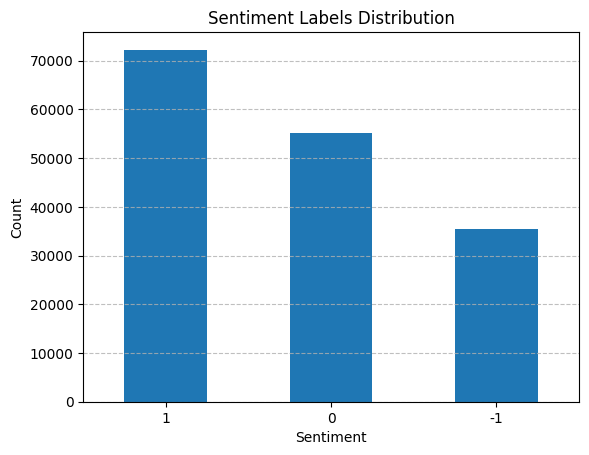

In [223]:
import matplotlib.pyplot as plt

count = df_cleaned["category"].value_counts()

plt.title("Sentiment Labels Distribution")

count.plot(kind="bar")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)

plt.ylabel("Count")

plt.grid(axis="y", linestyle="--", alpha=0.8)  # horizontal lines

plt.show()

We can see that there is a noticeable difference between the three classes. The positive class (1) has a count of over 70,000, the neutral class (0) has around 55,000, and the negative class (-1) has around 30,000.

This imbalance indicates that we must use stratified splitting in the later section.


# **5 Dataset Splitting**

Before being able to use the dataset, we need to partition it into three sets:

1. **Training** - used to train the model to learn and change its parameters
2. **Validation** - used to evaluate the model, comparing its predictions to correct answers for hyperparameter tuning
3. **Test** - used to test the model with new, unseen data

The following section will be dedicated solely to splitting the dataset. We will split the dataset with 70% for training, 15% for validation, and 15% for testing as this is a standard partitioning.

## **Splitting the dataset into Training, Validation, and Testing sets**

We'll first split the dataset into 70% and 30% parts by using Scikit-learn's `train_test_split` function. As mentioned earlier, the distribution of categories is imbalanced, so we have to use the function's `stratify` parameter to maintain an even proportion.


In [224]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(
    df_cleaned, test_size=0.3, stratify=df_cleaned["category"], random_state=5
)  # 70/30 split

print(train.shape, temp.shape)

(114059, 2) (48883, 2)


We now have our two sets for training and testing, but we're still missing one more for validation. We can split the 30% part into two halves of 15% so that we have a part for validation and the other part for testing.


In [225]:
validation, test = train_test_split(
    temp, test_size=0.5, stratify=temp["category"], random_state=5
)  # 15/15 split

print(train.shape, validation.shape, test.shape)

(114059, 2) (24441, 2) (24442, 2)


Now that we have our training, validation, and testing sets, we can use these on the models.


# **references**

Bird, S., & Loper, E. (2004, July). NLTK: The natural language toolkit. _Proceedings of the ACL Interactive Poster and Demonstration Sessions_, 214–217. https://aclanthology.org/P04-3031/

El-Demerdash, A. A., Hussein, S. E., & Zaki, J. F. W. (2021). Course evaluation based on deep learning and SSA hyperparameters optimization. _Computers, Materials & Continua, 71_(1), 941–959. https://doi.org/10.32604/cmc.2022.021839

George, M., & Murugesan, R. (2024). Improving sentiment analysis of financial news headlines using hybrid Word2Vec-TFIDF feature extraction technique. _Procedia Computer Science, 244_, 1–8.

Hussein, S. (2021). _Twitter sentiments dataset_. Mendeley.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research, 12_, 2825–2830.

Rani, D., Kumar, R., & Chauhan, N. (2022, October). Study and comparison of vectorization techniques used in text classification. In _2022 13th International Conference on Computing Communication and Networking Technologies (ICCCNT)_ (pp. 1–6). IEEE.

Wolfram Research. (2015). _DeleteStopwords_. https://reference.wolfram.com/language/ref/DeleteStopwords.html


# **appendix: `clean` wrapper function definition**

Below is the definition of the `clean` wrapper function that encapsulates all internal functions used in the cleaning pipeline.


In [226]:
clean??

Signature: clean(text: str) -> str
Source:   
def clean(text: str) -> str:
    """
    This is the main function for data cleaning (i.e., it calls all the cleaning functions in the prescribed order).

    This function should be used as a first-class function in a map.

    # Parameters
    * text: The string entry from a DataFrame column.
    * stopwords: stopword dictionary.

    # Returns
    Clean string
    """
    # cleaning on the base string
    text = normalize(text)
    text = rem_punctuation(text)
    text = rem_numbers(text)
    text = collapse_whitespace(text)

    return text
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

# **appendix: `find_spam_and_empty` wrapper function definition**

Below is the definition of the `find_spam_and_empty` wrapper function that encapsulates all internal functions for the spam detection algorithm.


In [227]:
find_spam_and_empty??

Signature: find_spam_and_empty(text: str, min_length: int = 3) -> str | None
Source:   
def find_spam_and_empty(text: str, min_length: int = 3) -> str | None:
    """
    Filter out empty text and unintelligible/spammy unintelligible substrings in the text.

    Spammy substrings:
    - Shorter than min_length
    - Containing non-alphabetic characters
    - Consisting of a repeated substring (e.g., 'aaaaaa', 'ababab', 'abcabcabc')

    # Parameters
    * text: input string.
    * min_length: minimum length of word to keep.

    # Returns
        Cleaned string, or None if empty after filtering.
    """
    cleaned_tokens = []
    for t in text.split():
        if len(t) < min_length:
            continue

        if re.search(r"(.)\1{2,}", t):
            continue

        min_diversity = 0.3 + (0.1 * min(len(t), 10) / 10)
        if len(set(t)) / len(t) < min_diversity:
            continue

        if re.match(r"^(.+)\1+", t):
            continue

        cleaned_tokens.append(t)



# **appendix: comparison of traditional vectorization techniques**

Traditional vectorization techniques include BoW and Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF weights each word based on its frequency in a document and its rarity across the corpus, reducing the impact of common words. BoW, in contrast, simply counts word occurrences without considering corpus-level frequency. In this project, BoW was chosen because stopwords were already removed during preprocessing, and the dataset is domain-specific <u>(Rani et al., 2022)</u>. In such datasets, frequent words are often meaningful domain keywords, so scaling them down (as TF-IDF would) could reduce the importance of these key terms in the feature representation.


# **appendix: `BagOfWordsModel` class definition**

Below is the definition of the `BagOfWordsModel` class that encapsulates the desired parameters.


In [228]:
BagOfWordsModel??

Init signature: BagOfWordsModel(texts: Iterable[str], min_freq: int | float | None = None)
Source:        
class BagOfWordsModel:
    """
    A Bag-of-Words representation for a text corpus.

    # Attributes
    * matrix (scipy.sparse.csr_matrix): The document-term matrix of word counts.
    * feature_names (list[str]): List of feature names corresponding to the matrix columns.
    *
    # Usage
    ```
    bow = BagOfWordsModel(df["lemmatized_str"])
    ```
    """

    def __init__(self, texts: Iterable[str], min_freq: int | float | None = None):
        """
        Initialize the BagOfWordsModel by fitting the vectorizer to the text corpus. This also filters out tokens
        that do not appear more than five times in the dataset.

        This sets its tokenizer to the word boundary tokenizer since the input, at this point, **should** be
        cleaned and processed text.

        This also uses both unigrams and bigrams, hence, at the worst case its space complexity is O(n^2).
